In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import (
    Dense,
    Conv2D,
    Flatten,
    Dropout,
    MaxPooling2D,
    BatchNormalization,
    LeakyReLU,
    ReLU,
)
from keras.optimizers import SGD, Adam
from keras.utils import image_dataset_from_directory


def base_preprocess(image, label):
    image = image / 255.0
    # image = image / 127.5 - 1
    return image, label


def preprocess(image, label):
    image, label = base_preprocess(image, label)
    thr = 0.005
    label += thr
    label = tf.clip_by_value(label, clip_value_min=0, clip_value_max=1 - thr * 9)
    return image, label


def gen_dataset(img_size, batch_size):
    # split_dataset()
    # バッチサイズ

    # データセットの読み込み
    train_dataset = image_dataset_from_directory(
        "./Flowers/Train",
        image_size=img_size,
        batch_size=batch_size,
        label_mode="categorical",  # クラス分類
        shuffle=True,
    )
    train_dataset = train_dataset.map(preprocess)

    val_dataset = image_dataset_from_directory(
        "./Flowers/Val",
        image_size=img_size,
        batch_size=batch_size,
        label_mode="categorical",
        shuffle=True,
    )
    val_dataset = val_dataset.map(base_preprocess)
    return train_dataset, val_dataset


In [6]:
from keras.losses import CategoricalCrossentropy
from keras.regularizers import l2
from keras.layers import RandomFlip, RandomZoom, RandomRotation
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint


def conv_factory(filters, l2_lambda, input_shape=None):
    kernel_size = (3, 3)
    if input_shape is None:
        conv = Conv2D(
            filters,
            kernel_size,
            kernel_regularizer=l2(l2_lambda),
            activation=None,
        )
    else:
        conv = Conv2D(
            filters,
            kernel_size,
            kernel_regularizer=l2(l2_lambda),
            activation=None,
            input_shape=input_shape,
        )
    return Sequential(
        [
            conv,
            LeakyReLU(),
            MaxPooling2D((2, 2)),
        ]
    )


batch_size = 32
img_size = (128, 128)
train_dataset, val_dataset = gen_dataset(img_size, batch_size)

X_spec, y_spec = train_dataset.element_spec
input_shape = X_spec.shape[1:]
num_classes = y_spec.shape[1:][0]

data_augmentation = Sequential(
    [
        RandomFlip("horizontal"),
        # RandomZoom(0.1),
        # RandomRotation(0.1),
    ]
)

initial_size = 32
l2_lambda = 5e-4
model = Sequential(
    [
        data_augmentation,
        conv_factory(initial_size, input_shape=input_shape, l2_lambda=l2_lambda),
        conv_factory(initial_size * 2, l2_lambda=l2_lambda),
        conv_factory(initial_size * 4, l2_lambda=l2_lambda),
        conv_factory(initial_size * 8, l2_lambda=l2_lambda),
        Flatten(),
        Dense(256, kernel_regularizer=l2(l2_lambda), activation="relu"),
        Dropout(0.5),
        Dense(
            num_classes,
            kernel_regularizer=l2(l2_lambda),
            activation="softmax",
        ),
    ]
)


# モデルを保存するファイルパス
checkpoint_filepath = "best_scratch_model.h5"

# コールバックの設定
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,  # ベストモデルの保存先
    save_best_only=True,  # ベストモデルのみ保存
    monitor="val_accuracy",  # 評価指標（val_loss が最小のとき保存）
    mode="max",  # 最小値を目指す
    verbose=1,
)

early_stopping = EarlyStopping(monitor="val_loss", patience=7, verbose=1, mode="min")

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-8)

loss = CategoricalCrossentropy()

# モデルの学習
model.compile(loss=loss, optimizer="adam", metrics=["accuracy"])
EPOCHS = 100
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[
        reduce_lr,
        model_checkpoint_callback,
        # early_stopping,
    ],
)

Found 480 files belonging to 10 classes.
Found 120 files belonging to 10 classes.
Epoch 1/100
13/15 [=========================>....] - ETA: 0s - loss: 2.3365 - accuracy: 0.2091
Epoch 1: val_accuracy improved from -inf to 0.35000, saving model to best_scratch_model.h5
15/15 [==============================] - 2s 55ms/step - loss: 2.3134 - accuracy: 0.2062 - val_loss: 2.0006 - val_accuracy: 0.3500 - lr: 0.0010
Epoch 2/100
15/15 [==============================] - ETA: 0s - loss: 1.8802 - accuracy: 0.4250
Epoch 2: val_accuracy improved from 0.35000 to 0.53333, saving model to best_scratch_model.h5
15/15 [==============================] - 1s 42ms/step - loss: 1.8802 - accuracy: 0.4250 - val_loss: 1.4742 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 3/100
14/15 [===========================>..] - ETA: 0s - loss: 1.6331 - accuracy: 0.5268
Epoch 3: val_accuracy improved from 0.53333 to 0.58333, saving model to best_scratch_model.h5
15/15 [==============================] - 1s 40ms/step - loss: 1.6212

KeyboardInterrupt: 

Text(0, 0.5, 'Accuracy')

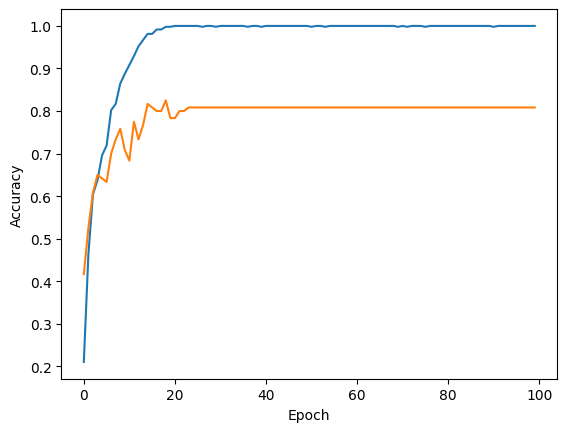

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")


Text(0, 0.5, 'loss')

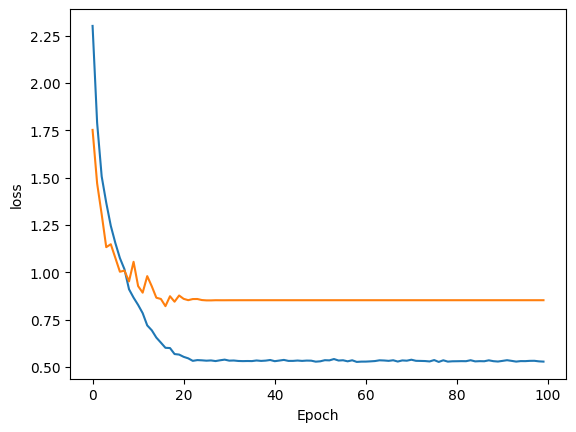

In [4]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("loss")


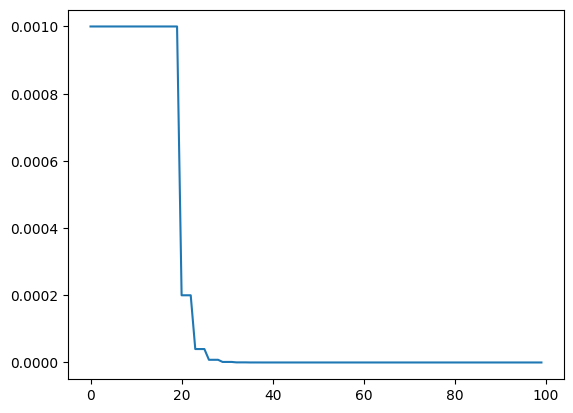

In [5]:
plt.plot(history.history['lr'])

In [ ]:
from keras.models import load_model

batch_size = 32
img_size = (128, 128)
train_dataset, val_dataset = gen_dataset(img_size, batch_size)
# ベストモデルをロード
path = 'best_scratch_model.h5'
best_model = load_model(path)

# テストデータで評価
test_loss, test_acc = best_model.evaluate(val_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

Found 480 files belonging to 10 classes.
Found 120 files belonging to 10 classes.
4/4 [==============================] - 0s 8ms/step - loss: 0.7373 - accuracy: 0.8583
Test Accuracy: 0.8583
